In [1]:
%load_ext autoreload
from einops import rearrange
from glob import glob
import torch
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
import os
import random
from models.perciever import Perceiver
from models.perciever_rnn import PerceiverRNN, MLPPredictor
from data_prep.nvidia import NvidiaDatasetRNN


In [2]:
dataset_path = 'data_stuff/rally-estonia-cropped-antialias'
#dataset_path = '/gpfs/space/projects/rally2023/rally-estonia-cropped-antialias'
dataset_subdirs = glob(dataset_path + '/*')
dataset_subdir = dataset_subdirs[0]
print(dataset_subdir)
image_paths = glob(dataset_subdir + '/front_wide/*.png')
image = Image.open(image_paths[0])
pixels = list(image.getdata())
print(len(pixels))
pixel_tens = torch.Tensor(pixels)
print(pixel_tens.shape)
pixel_tens = pixel_tens.view(68, 264, 3)
print(pixel_tens.shape)

data_stuff/rally-estonia-cropped-antialias\2021-05-20-12-36-10_e2e_sulaoja_20_30
17952
torch.Size([17952, 3])
torch.Size([68, 264, 3])


In [3]:
batch = pixel_tens.view(1, *pixel_tens.shape)
print(batch.dtype)

torch.float32


In [4]:
pmodel = Perceiver(
    input_channels = 3,          # number of channels for each token of the input
    input_axis = 2,              # number of axis for input data (2 for images, 3 for video)
    num_freq_bands = 6,          # number of freq bands, with original value (2 * K + 1)
    max_freq = 10.,              # maximum frequency, hyperparameter depending on how fine the data is
    depth = 1,                   # depth of net. The shape of the final attention mechanism will be:
                                 #   depth * (cross attention -> self_per_cross_attn * self attention)
    num_latents = 256,           # number of latents, or induced set points, or centroids. different papers giving it different names
    latent_dim = 512,            # latent dimension
    cross_heads = 1,             # number of heads for cross attention. paper said 1
    latent_heads = 8,            # number of heads for latent self attention, 8
    cross_dim_head = 64,         # number of dimensions per cross attention head
    latent_dim_head = 64,        # number of dimensions per latent self attention head
    num_classes = 1,          # output numb"er of classes
    attn_dropout = 0.,
    ff_dropout = 0.,
    weight_tie_layers = False,   # whether to weight tie layers (optional, as indicated in the diagram)
    fourier_encode_data = True,  # whether to auto-fourier encode the data, using the input_axis given. defaults to True, but can be turned off if you are fourier encoding the data yourself
    self_per_cross_attn = 2      # number of self attention blocks per cross attention
)

steering_classifier = MLPPredictor(512, 64)
percieverRNN = PerceiverRNN(pmodel, steering_classifier)

steering, latents = percieverRNN.forward(batch)
percieverRNN.forward(batch, latents)

(tensor([[0.0865]], grad_fn=<AddmmBackward0>),
 tensor([[[ 2.4969, -0.9299, -1.9073,  ...,  0.4411, -1.0086, -1.6837],
          [-0.8180,  0.2791, -0.8043,  ...,  0.4415,  0.7478, -1.6143],
          [ 1.3865, -0.3546, -0.5898,  ...,  0.5569,  1.3265, -1.3639],
          ...,
          [-0.2290,  1.0546, -2.4688,  ...,  0.7450, -2.8610, -1.2271],
          [ 2.1929, -0.5899, -0.4598,  ...,  1.6010, -1.1847, -1.6549],
          [ 0.1224, -1.9824, -0.9585,  ...,  0.6984,  0.6033, -1.9742]]],
        grad_fn=<AddBackward0>))

In [5]:

# RNN dataloader

dataset_path = Path('./data_stuff/rally-estonia-cropped-antialias')
data_dirs = os.listdir(dataset_path)[:2]
random.shuffle(data_dirs)
split_index = int(0.5 * len(data_dirs))

train_paths = [dataset_path / dir_name for dir_name in data_dirs[:split_index]]

train_dataset = NvidiaDatasetRNN(train_paths, 8, 4)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True,
                                                   num_workers=1, pin_memory=True,
                                                   persistent_workers=True, collate_fn=train_dataset.collate_fn)

[NvidiaDataset] Using default transform: Compose(
)


c:\Users\Gordei\Desktop\Univer 2\2 sem\nns\proj\data_prep\nvidia.py:97: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  frames_df["turn_signal"].fillna(1, inplace=True)


data_stuff\rally-estonia-cropped-antialias\2021-05-20-12-36-10_e2e_sulaoja_20_30: length=12025, filtered=1


In [8]:
# RNN Forward pass

batch = next(iter(train_loader)) 

images = batch[0]['image'] # shape B, T, C, H, W
targets = batch[1] # shape B, T

images = rearrange(images, 'b t c h w -> t b h w c')
targets = rearrange(targets, 'b t -> t b')
latents = None
for t in range(images.shape[0]):
    t_img_batch = images[t]
    steering, latents = percieverRNN.forward(t_img_batch)



tensor([[[ 1.7613, -1.3985, -0.9694,  ...,  0.0991, -0.9880, -0.9187],
         [-1.1845, -0.0990,  0.1122,  ...,  0.1589,  0.6732, -0.9606],
         [ 1.0997, -0.8763,  0.4044,  ...,  0.0166,  1.4045, -1.0091],
         ...,
         [-0.6887,  0.8200, -1.3660,  ...,  0.1647, -2.1567,  0.3804],
         [ 1.1211, -1.0207,  0.3473,  ...,  0.9723, -1.4635, -0.7137],
         [-0.9201, -2.4882,  0.2962,  ...,  0.0355,  0.6365, -0.8462]],

        [[ 1.7752, -1.3971, -0.9826,  ...,  0.1019, -0.9876, -0.9321],
         [-1.1756, -0.0957,  0.0987,  ...,  0.1652,  0.6686, -0.9723],
         [ 1.1083, -0.8721,  0.3932,  ...,  0.0262,  1.4012, -1.0163],
         ...,
         [-0.6794,  0.8240, -1.3830,  ...,  0.1732, -2.1664,  0.3582],
         [ 1.1382, -1.0138,  0.3389,  ...,  0.9818, -1.4589, -0.7258],
         [-0.9032, -2.4800,  0.2801,  ...,  0.0468,  0.6367, -0.8640]],

        [[ 1.7809, -1.3976, -0.9897,  ...,  0.1030, -0.9880, -0.9395],
         [-1.1714, -0.0944,  0.0902,  ...,  0

torch.Size([8, 3, 68, 264])

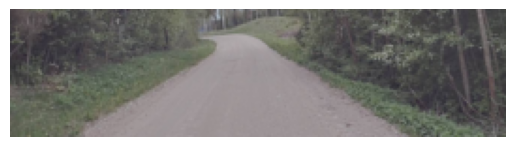

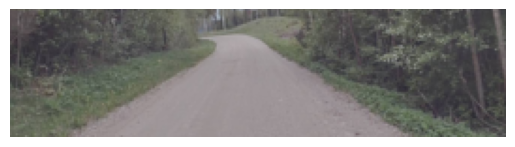

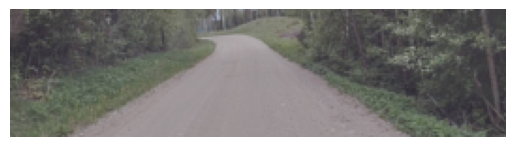

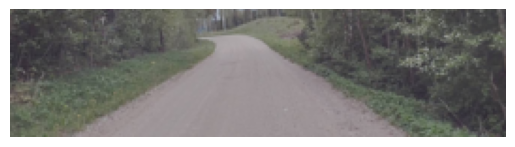

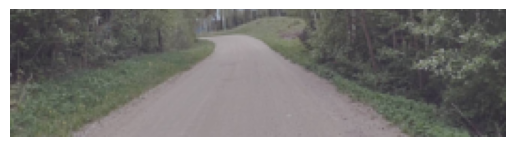

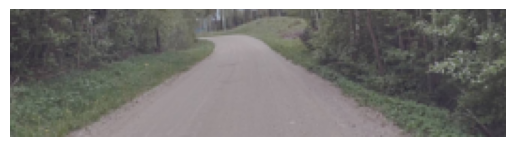

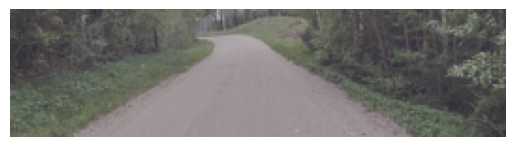

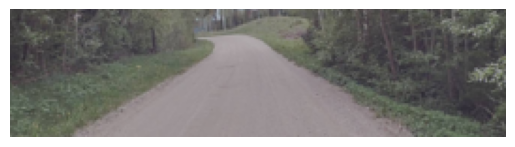

In [8]:
tens = next(iter(train_loader))[0]['image'][0]
for i in range(len(tens)):
    plt.imshow(tens[i].permute(1, 2, 0))
    plt.axis('off')
    plt.show()

torch.Size([16, 8, 3, 68, 264])